# How to Determine if a Chessboard Square is Occupied or Empty

## Introduction

![](assets/d4pawn.jpg)
<center>_Is there a piece in the square?_</center>

The answer may be obvious to us, but how can we write a program that can answer this question as accurately as we can? In this notebook we will approach this problem in two ways:

**Using**<br/>
1. **conventional computer vision and our knowledge of what a chess piece looks like**
2. **machine learning**

## Solving the Problem Using Intuition

First let's break down what we know. The pieces are orange or green and the squares are either white or black. 

In [37]:
import project
import numpy as np

In [38]:
with open(project.path('data', 'processed', 'dataset1.npz'), 'r') as f:
    d = np.load(f)
    X_train, X_val, y_train, y_val = d['X_train'], d['X_val'], d['y_train'], d['y_val']

In [124]:
import cv2

norm_imgs = X_train.reshape((-1,60,60,3))
bgr_imgs = ((norm_imgs + 1.0) * 127.5).astype(np.uint8)
imgs = np.array([cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB) for bgr_img in bgr_imgs])

y_train = y_train.argmax(axis=1)
y_val = y_val.argmax(axis=1)

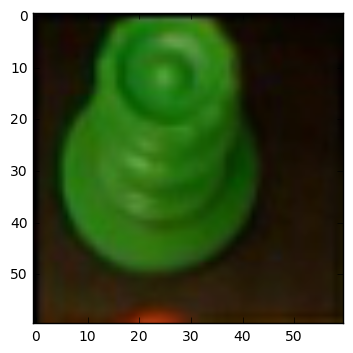

In [170]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0])
plt.show()

First we will convert the image to the HSV color space.

![HSV](assets/HSV.png)

In [78]:
x_kern = np.arange(0, 4, 1, float)
y_kern = x_kern[:,np.newaxis]
x_kern0 = y_kern0 = 4 // 2
OPENING_KERNEL = np.uint8(np.exp(-4*np.log(2) * ((x_kern-x_kern0)**2 + (y_kern-y_kern0)**2) / 2**2) * 255)

def mask(img, lower, upper, kernel):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

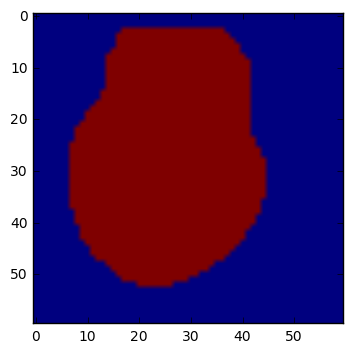

In [139]:
img = imgs[0]
green_mask = mask(img, (32,10,45), (60,255,255), OPENING_KERNEL) * 255.0
orange_mask = mask(img, (0,160,64), (10,255,255), OPENING_KERNEL) * 255.0
mask_img = cv2.bitwise_or(green_mask, orange_mask)
plt.imshow(mask_img)
plt.show()

Let's come up with a way to measuring error of our classification method.

In [106]:
def combined_mask(img):
    green_mask = mask(img, (32,10,45), (60,255,255), OPENING_KERNEL) * 255.0
    orange_mask = mask(img, (0,160,64), (10,255,255), OPENING_KERNEL) * 255.0
    return cv2.bitwise_or(green_mask, orange_mask)

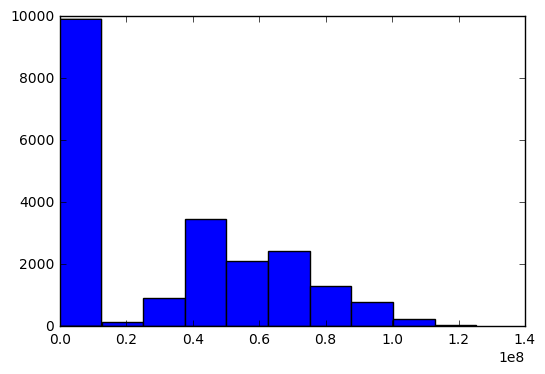

In [110]:
sums = np.array([np.sum(combined_mask_sum(img)) for img in imgs])

plt.hist(sums)
plt.show()

In [161]:
from sklearn.metrics import mean_squared_error

pred = np.bitwise_not(sums > 880.0)
e = mean_squared_error(pred, y_train)
print "Error: {}".format(e)

Error: 0.0315507770318


Confusion matrix, without normalization
[[11304     0]
 [  672  9323]]


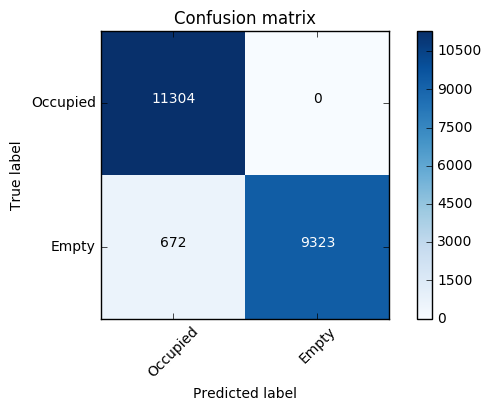

In [162]:
from sklearn.metrics import confusion_matrix
from helpers import plot_confusion_matrix


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, pred)
np.set_printoptions(precision=2)
class_names = ['Occupied', 'Empty']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [193]:
size = imgs.shape[1]
x = np.arange(0, size, 1, float)
y = x[:,np.newaxis]
x0 = y0 = size // 2
MASK_WEIGHTS = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / (size*0.15)**2)

def weighted_combined_mask(img):
    return combined_mask(img) * MASK_WEIGHTS

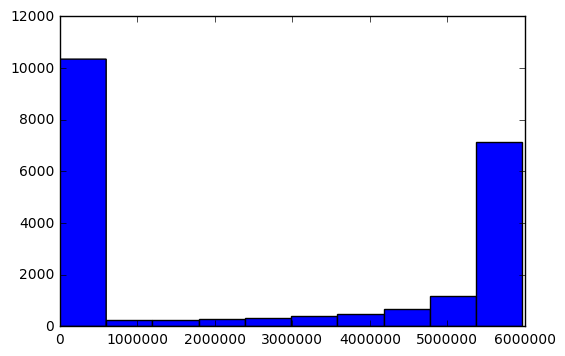

In [194]:
weighted_sums = np.array([np.sum(weighted_combined_mask(img)) for img in imgs])
plt.hist(weighted_sums)
plt.show()

In [213]:
pred = np.bitwise_not(weighted_sums > 1200.0)
e = mean_squared_error(pred, y_train)
print "Error: {}".format(e)

Error: 0.000985961782243


Confusion matrix, without normalization
[[11297     7]
 [   14  9981]]


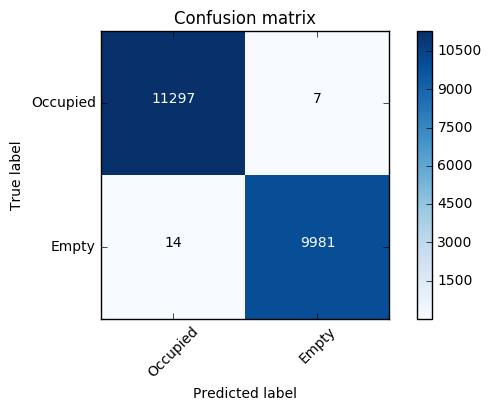

In [218]:
cnf_matrix = confusion_matrix(y_train, pred)
class_names = ['Occupied', 'Empty']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [215]:
incorrect_indexes = np.where(pred != y_train)[0]

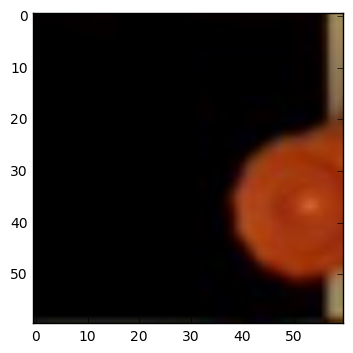

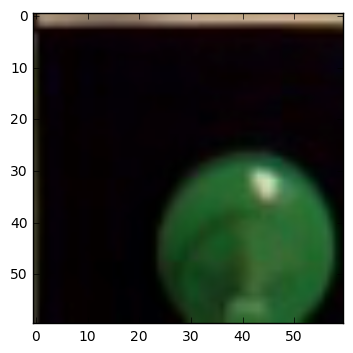

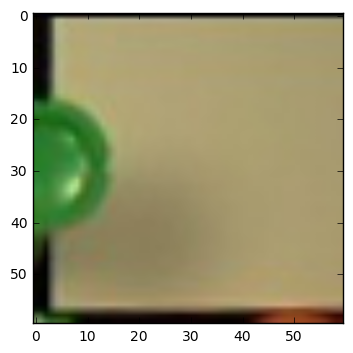

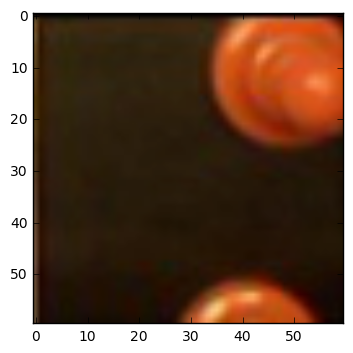

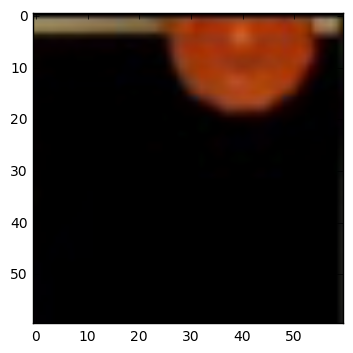

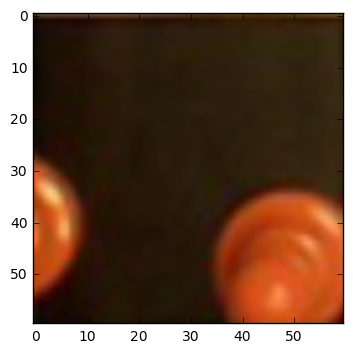

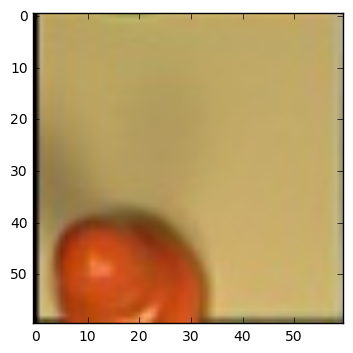

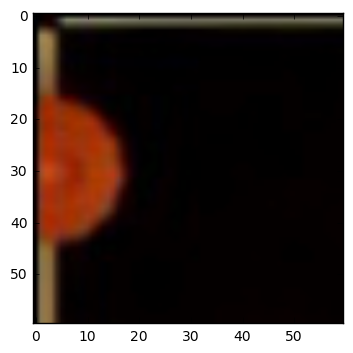

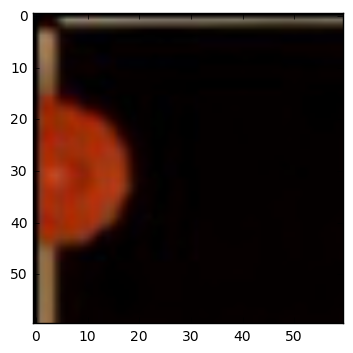

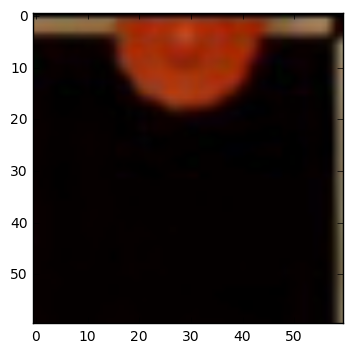

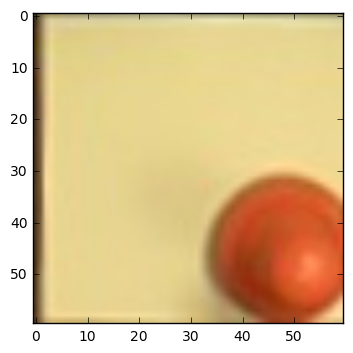

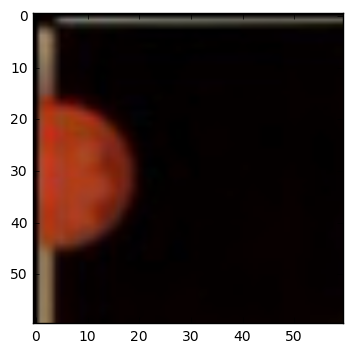

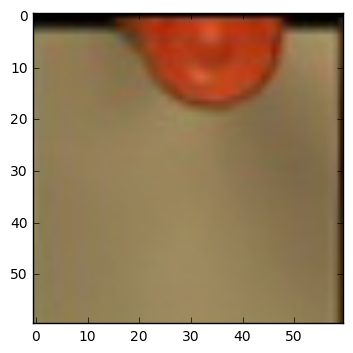

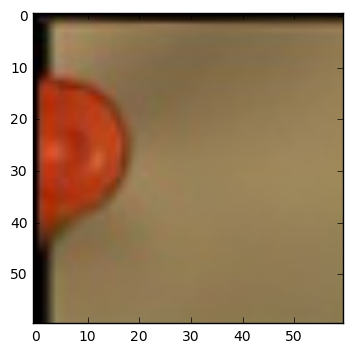

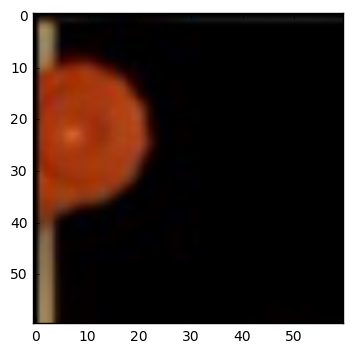

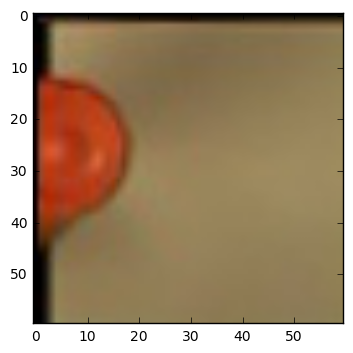

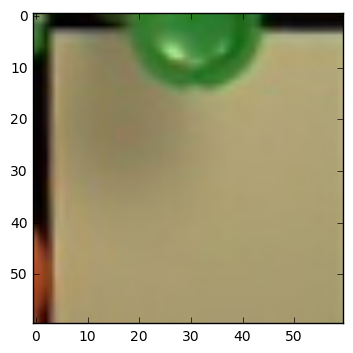

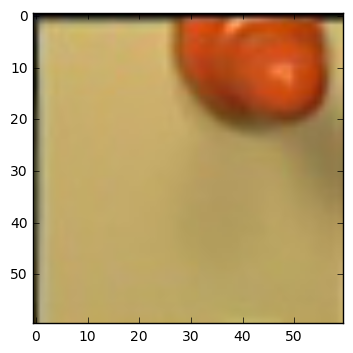

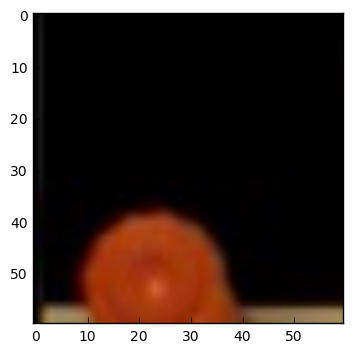

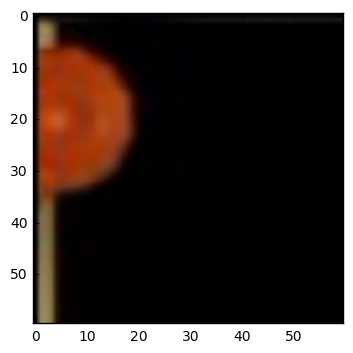

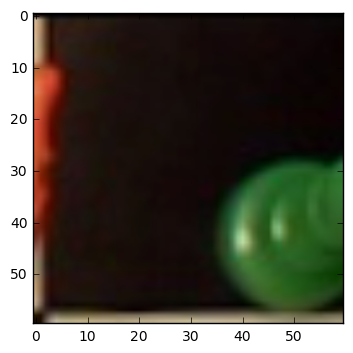

In [216]:
for i in incorrect_indexes:
    plt.imshow(imgs[i])
    plt.show()

## Solving the Problem Using Machine Learning

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [5]:
y_train = y_train.argmax(axis=1)
y_val = y_val.argmax(axis=1)

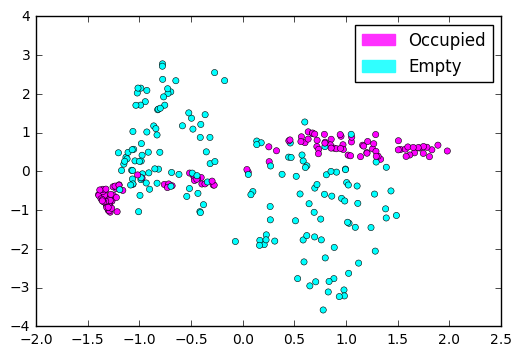

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

X_plot = X_train_pca[:300]
y_plot = y_train[:300]

sc = plt.scatter(X_plot[:,0], X_plot[:,1], c=y_plot, cmap=cm.cool, linewidths=0.4)
occupied_patch = Patch(color='#ff30ff', label='Occupied')
empty_patch = Patch(color='#30ffff', label='Empty')
plt.legend(handles=[occupied_patch, empty_patch])
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

In [223]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_pca, y_train)
svc_pred = svc.predict(X_train_pca)
print mean_squared_error(svc_pred, y_train)

0.000234752805296


In [234]:
import pickle

with open(project.path('data', 'processed', 'square_presence_detector.pca'), 'w') as f:
    pickle.dump(pca, f)

with open(project.path('data', 'processed', 'square_presence_detector.svc'), 'w') as f:
    pickle.dump(svc, f)

In [237]:
from raspberryturk.external.data.dataset import Dataset
p = project.path('data', 'processed', 'dataset1.npz')
d = Dataset.load_file(p)

(21299, 10800)

Confusion matrix, without normalization
[[11300     4]
 [    1  9994]]


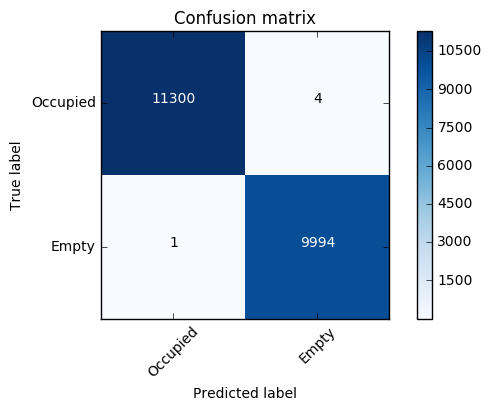

In [225]:
cnf_matrix = confusion_matrix(y_train, svc_pred)
class_names = ['Occupied', 'Empty']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

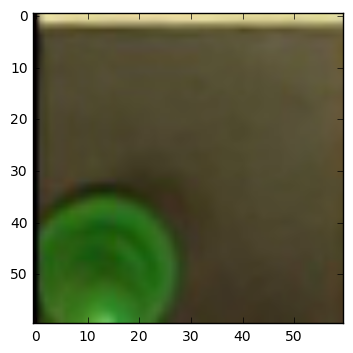

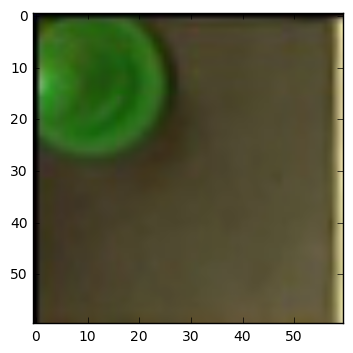

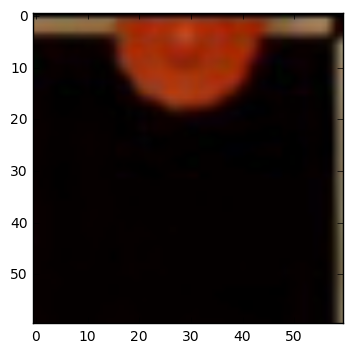

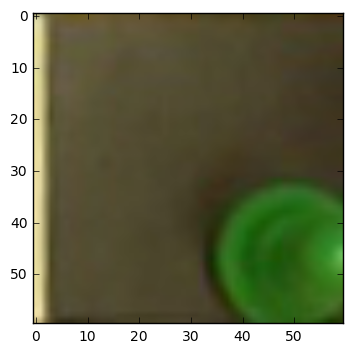

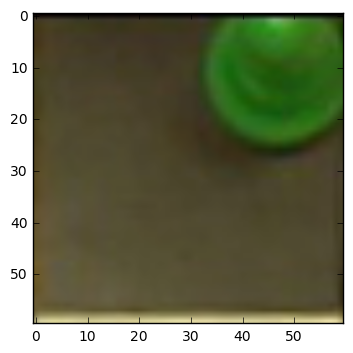

In [227]:
incorrect_indexes = np.where(svc_pred != y_train)[0]
for i in incorrect_indexes:
    plt.imshow(imgs[i])
    plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train_pca, y_train)
knc_pred = knc.predict(X_val_pca)
print mean_squared_error(knc_pred, y_val)

0.0018779342723


In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_pca, y_train)
rfc_pred = rfc.predict(X_val_pca)
print mean_squared_error(rfc_pred, y_val)

0.00169014084507


In [11]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)
mlp_pred = mlp.predict(X_val_pca)
print mean_squared_error(mlp_pred, y_val)

0.00037558685446


In [12]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train_pca, y_train)
sgd_pred = sgd.predict(X_val_pca)
print mean_squared_error(sgd_pred, y_val)

0.191549295775


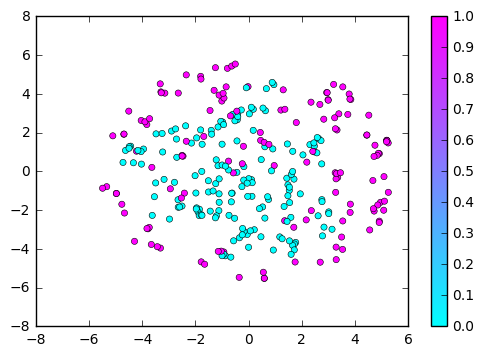

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE()
X_train_tsne = tsne.fit_transform(X_train_pca)

X_plot_tsne = X_train_tsne[:300]
y_plot_tsne = y_train[:300]

sc = plt.scatter(X_plot_tsne[:,0], X_plot_tsne[:,1], c=y_plot_tsne, cmap=cm.cool, linewidths=0.4)
plt.colorbar(sc)
plt.show()